In [108]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from math import radians, sin, cos, sqrt, atan2

### K-means algorithm for generating clusters

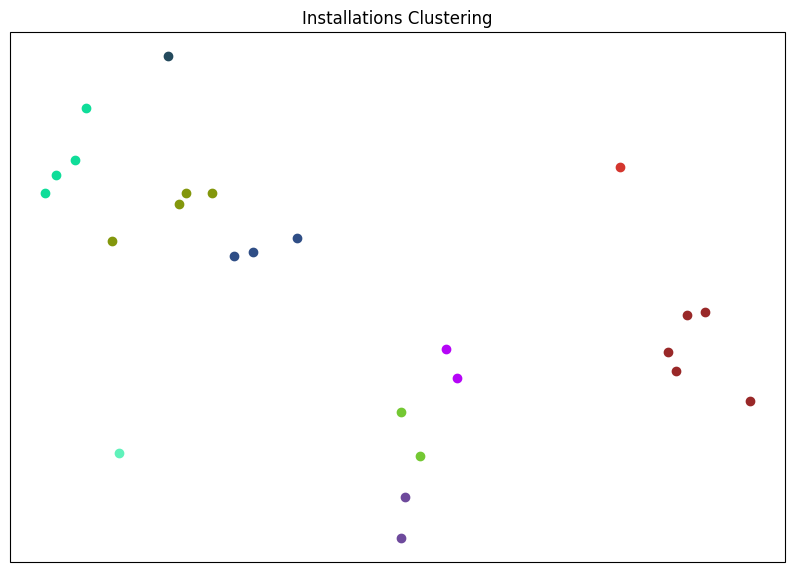

Cluster 7: ['APT', 'OSS'], Total Cargo_per_visit: 30.0
Cluster 10: ['ASL', 'GFA', 'GFB', 'GFC'], Total Cargo_per_visit: 86.0
Cluster 5: ['DAB'], Total Cargo_per_visit: 40.0
Cluster 3: ['DSA', 'STA', 'STB', 'STC'], Total Cargo_per_visit: 90.25
Cluster 8: ['DSS'], Total Cargo_per_visit: 29.0
Cluster 6: ['KVB', 'NLN', 'VAL'], Total Cargo_per_visit: 38.0
Cluster 1: ['MID'], Total Cargo_per_visit: 14.0
Cluster 9: ['OSC', 'OSE'], Total Cargo_per_visit: 43.2
Cluster 4: ['OSO', 'VFB'], Total Cargo_per_visit: 28.5
Cluster 2: ['TEN', 'TEQ', 'TRB', 'TRC', 'TRO'], Total Cargo_per_visit: 56.0


In [109]:
data = pd.read_csv('clustering_input.csv', delimiter=';')
coordinates = data[['Latitude', 'Longitude']]

clusters = []
cluster_summary = {}

def cluster_with_demand_constraint(num_clusters, data):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data)
    
    labels = kmeans.labels_

    clustered_installations = {}
    for i, label in enumerate(labels):
        if label not in clustered_installations:
            clustered_installations[label] = []
        clustered_installations[label].append(data.index[i])

    return labels, clustered_installations

def generate_cluster_colors(num_clusters):
    np.random.seed(42)
    colors = np.random.rand(num_clusters, 3)
    return colors

def plot_clusters_on_map(data, labels, colors):
    plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    for i, label in enumerate(labels):
        lat, lon = data.iloc[i]
        color = colors[label]
        ax.scatter(lon, lat, color=color, marker='o', transform=ccrs.PlateCarree(), zorder=5)
    ax.coastlines()
    plt.title('Installations Clustering')
    plt.show()

def print_clustered_installations(clustered_installations, data):
    for cluster, installations in clustered_installations.items():
        ids = [data.iloc[i]['ID'] for i in installations]
        
        max_visits = max(data.iloc[i]['Visits_per_week'] for i in installations)
        cargo_sum = sum(data.iloc[i]['Cargo_per_visit'] * data.iloc[i]['Visits_per_week'] / max_visits for i in installations)
        
        print(f"Cluster {cluster + 1}: {ids}, Total Cargo_per_visit: {cargo_sum}")
        clusters.append(ids)

        cluster_summary[cluster + 1] = {'platform': ''.join(ids), 'avg_q': cargo_sum}

def save_cluster_summary_to_csv(cluster_summary, filename='output_platforms_demand.csv'):
    df = pd.DataFrame.from_dict(cluster_summary, orient='index')
    df.to_csv(filename, index=False, sep=';')

def main():
    num_clusters = 10 #ENDRE TIL ØNSKET ANTALL CLUSTERS
    labels, clustered_installations = cluster_with_demand_constraint(num_clusters, coordinates)
    colors = generate_cluster_colors(num_clusters)
    plot_clusters_on_map(coordinates, labels, colors)
    print_clustered_installations(clustered_installations, data)
    save_cluster_summary_to_csv(cluster_summary)

if __name__ == "__main__":
    main()

### Create distance matrix based on the generated clusters

In [110]:
def calculate_distance(lat1, lon1, lat2, lon2):
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = 6371 * c  
    return distance

clusters_list = [['MON']]
for cluster in clusters:
    clusters_list.append(cluster)

installations = pd.read_csv('distance_matrix_input.csv', delimiter=';')

cluster_centroids = []
cluster_names = []
for cluster in clusters_list:
    centroid_lat = installations.loc[installations['ID'].isin(cluster), 'Latitude'].mean()
    centroid_lon = installations.loc[installations['ID'].isin(cluster), 'Longitude'].mean()
    cluster_centroids.append((centroid_lat, centroid_lon))
    cluster_name = ''.join(cluster)
    cluster_names.append(cluster_name)

new_distance_matrix = pd.DataFrame(index=cluster_names, columns=cluster_names)

def km_to_nm(km):
    return km * 0.539957

for i in range(len(clusters_list)):
    for j in range(len(clusters_list)):
        distance_km = calculate_distance(cluster_centroids[i][0], cluster_centroids[i][1], cluster_centroids[j][0], cluster_centroids[j][1])
        distance_nm = km_to_nm(distance_km)
        new_distance_matrix.iloc[i, j] = round(distance_nm,2)

new_distance_matrix.to_csv('output_distance_matrix_kmeans.csv', sep=';', index_label='from/to')